In [1]:
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

from keras import Sequential
from keras.layers import Dense

import keras_tuner as kt

import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf 
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers
import rasterio

Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Channels: 4
Processing images with dimensions: 201x201, Chan

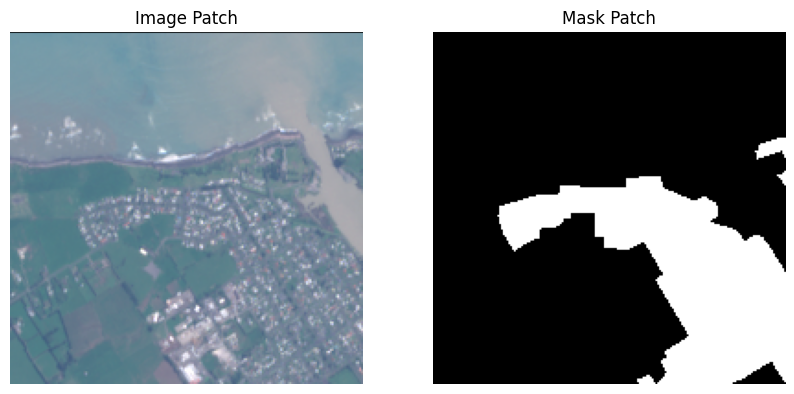

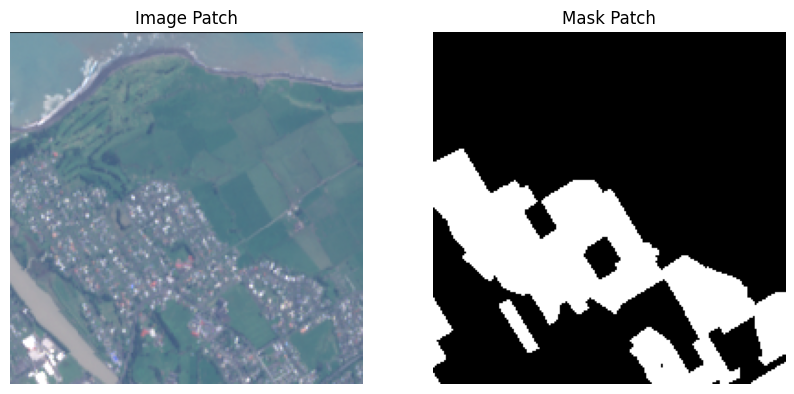

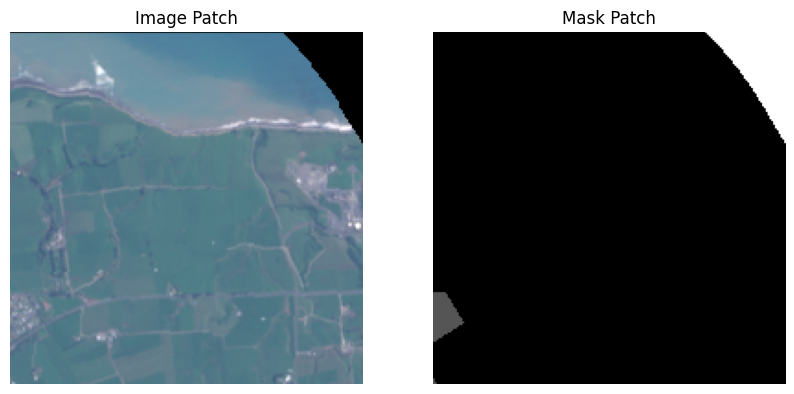

In [3]:
import os
import numpy as np
import rasterio
from rasterio.plot import show
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Initialize MinMaxScaler
minmaxscaler = MinMaxScaler()

# Parameter
image_patch_size = 192  # Patch size
dataset_root_folder = r"files"
dataset_name = 'Occupancy_task'

# Datasets
image_dataset = []
mask_dataset = []

# Loop through image and mask types
for image_type in ['images', 'mask']:
    image_extension = 'tif'  # GeoTIFF extension

    for image_id in range(0, 1000):  # Adjust the range as needed
        image_path = f'{dataset_root_folder}/{dataset_name}/{image_type}/image_{image_id}.{image_extension}'
        
        if not os.path.exists(image_path):
            continue  # Skip if the image does not exist

        # Open the GeoTIFF file
        with rasterio.open(image_path) as src:
            image = src.read()  # Read all bands
            image = np.moveaxis(image, 0, -1)  # Reorder axes to (height, width, channels)

        # Debugging: Check the shape of the image
        print(f"Processing {image_type} with dimensions: {image.shape[0]}x{image.shape[1]}, Channels: {image.shape[2]}")

        # Process RGB or grayscale images
        if image.shape[2] > 3:  # If more than 3 bands, keep only RGB
            image = image[:, :, :3]

        # Normalize 16-bit images to 8-bit
        if image.dtype == np.uint16:
            image = (image / 256).astype(np.uint8)

        # Resize image to be divisible by the patch size
        size_x = (image.shape[1] // image_patch_size) * image_patch_size
        size_y = (image.shape[0] // image_patch_size) * image_patch_size
        image = image[:size_y, :size_x, :]

        # Patchify the image
        patched_images = patchify(image, (image_patch_size, image_patch_size, image.shape[2]), step=image_patch_size)

        # Append patches to the dataset
        for i in range(patched_images.shape[0]):
            for j in range(patched_images.shape[1]):
                if image_type == 'images':
                    individual_patched_image = patched_images[i, j, 0]
                    # Normalize the patch
                    individual_patched_image = minmaxscaler.fit_transform(
                        individual_patched_image.reshape(-1, individual_patched_image.shape[-1])
                    ).reshape(individual_patched_image.shape)
                    image_dataset.append(individual_patched_image)
                elif image_type == 'mask':
                    individual_patched_mask = patched_images[i, j, 0]
                    mask_dataset.append(individual_patched_mask)

# Convert lists to numpy arrays
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

# Debugging: Print dataset details
print(f"Image dataset shape: {image_dataset.shape}")
print(f"Mask dataset shape: {mask_dataset.shape}")
print("Length of image dataset:", len(image_dataset))
print("Length of mask dataset:", len(mask_dataset))

# Visualize some images and masks
for i in range(3):  # Visualize 3 random patches
    plt.figure(figsize=(10, 5))
    
    # Image visualization
    plt.subplot(1, 2, 1)
    plt.title("Image Patch")
    plt.imshow(image_dataset[i] / np.max(image_dataset[i]))  # Normalize for visualization
    plt.axis('off')

    # Mask visualization
    plt.subplot(1, 2, 2)
    plt.title("Mask Patch")
    plt.imshow(mask_dataset[i], cmap='gray')
    plt.axis('off')
    
    plt.show()


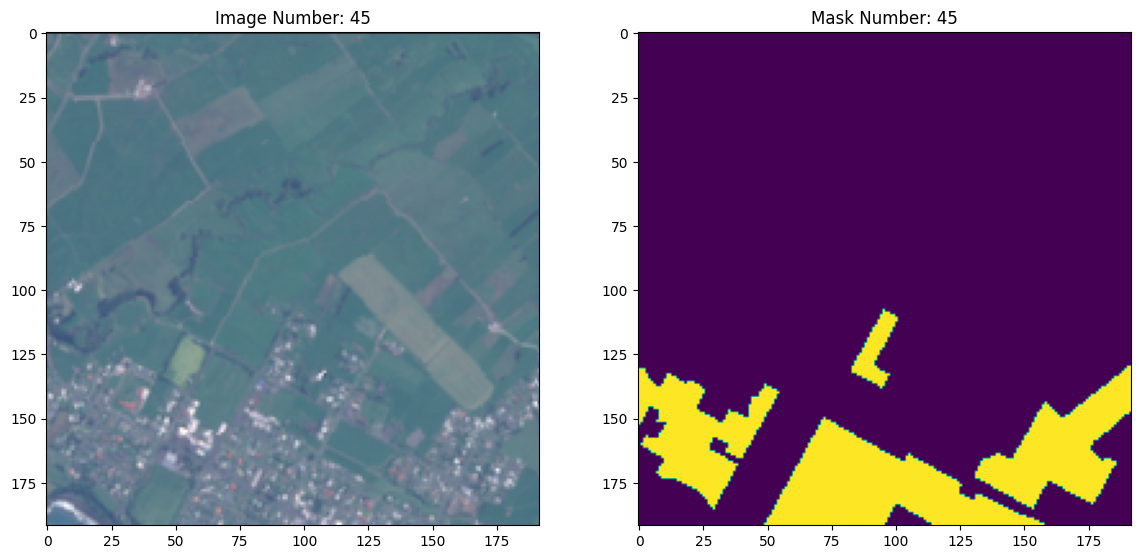

In [4]:
# Assume image_dataset and mask_dataset are your datasets
image_number = random.randint(0, len(image_dataset) - 1)

plt.figure(figsize=(14, 8))

# Display the image with the image number
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.title(f'Image Number: {image_number}')

# Display the mask with the mask number (same as image number in this case)
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.title(f'Mask Number: {image_number}')


plt.show()

In [5]:
### Assuming label pixel value rather than color

label = individual_patched_mask

import numpy as np

# Assuming mask_dataset contains masks with pixel values where:
# 1 = Building
# 0 = Background

def rgb_to_label(label):
    # If the input mask is 3D, we take only the first channel
    # Typically, mask images may be RGB (3-channel), but the values are same across channels
    label_segment = np.zeros(label.shape[:2], dtype=np.uint8)  # Initialize label array with 2D shape
    # Using only one channel for the classification (assuming the image is grayscale or a single band is enough)
    label_segment[label[:, :, 0] == 1] = 1  # Assign building class (1) based on the first channel
    label_segment[label[:, :, 0] == 0] = 0  # Assign background class (0) based on the first channel
    return label_segment

# Convert all mask images in the dataset
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)  # Add back the channel dimension if needed

# Print unique labels to confirm the mask conversion
print("Total unique labels based on masks: ", np.unique(labels))

Total unique labels based on masks:  [0 1]


Randomly selected image ID: 204


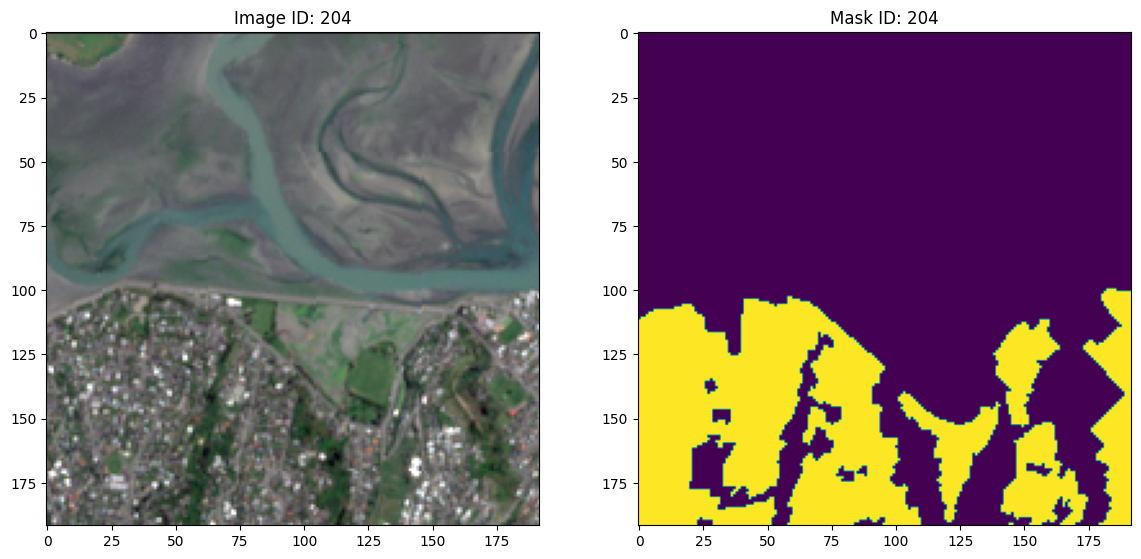

In [6]:
# visualization 

# Generate a random index within the range of the dataset
random_image_id = random.randint(0, len(image_dataset) - 1)

# Print the randomly selected image ID
print(f"Randomly selected image ID: {random_image_id}")

# Plot the image and corresponding mask
plt.figure(figsize=(14, 8))

plt.subplot(121)
plt.title(f"Image ID: {random_image_id}")
plt.imshow(image_dataset[random_image_id])

plt.subplot(122)
plt.title(f"Mask ID: {random_image_id}")
plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:, :, 0], alpha=0.5)

plt.show()

In [7]:
n_classes = len(np.unique(labels))
n_classes

from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)


print(len(np.unique(labels)))
print(labels_cat.shape)

2
(272, 192, 192, 2)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.1, random_state = 42) ## can change test_size and random_state on usecases

print(X_train.shape)  ## Imagery
print(X_test.shape)
print(y_train.shape)   ## labels
print(y_test.shape)

image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

(244, 192, 192, 3)
(28, 192, 192, 3)
(244, 192, 192, 2)
(28, 192, 192, 2)
192
192
3
2


In [9]:
import tensorflow
from PIL import Image
import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
weights = [ 0.5, 0.5 ]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

Segmentation Models: using `keras` framework.


In [10]:
def multi_unet_model(n_classes=2, IMG_HEIGHT=192, IMG_WIDTH=192, IMG_CHANNELS=3):
#Build the model
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
  s = inputs
  #Contraction path
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.2)(c1)  # Original 0.1
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.2)(c2)  # Original 0.1
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.2)(c8)  # Original 0.1
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.2)(c9)  # Original 0.1
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  #NOTE: Compile the model in the main program to make it easy to test with various loss functions
  #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  #model.summary()
  return model

In [11]:
metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=image_height, IMG_WIDTH=image_width, IMG_CHANNELS=image_channels)

model = get_model()


In [12]:
#model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

model.summary()

model.input.shape

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 192, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 192, 192, 16  0           ['conv2d[0][0]']                 
                                )                                                             

TensorShape([None, 192, 192, 3])

In [17]:
#### Training for direct X-train and  y_train

from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(
    r"NZ_250images_zones_checkpoint__{epoch:02d}_full_model.h5",
    monitor='val_loss',
    save_best_only= True,  # Set to False to save at each epoch
    save_weights_only=False,  # Set to False to save the entire model
    mode="auto",
    save_freq="epoch"
)

# Fit the model with callbacks
model_final = model.fit(
    X_train, y_train,
    batch_size=32,
    verbose=1,
    epochs=100,
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks=[checkpoint]
)


Epoch 1/100
8/8 [==============================] - 18s 2s/step - loss: 0.3031 - accuracy: 0.8204 - jacard_coef: 0.6628 - val_loss: 0.2809 - val_accuracy: 0.8322 - val_jacard_coef: 0.6634
Epoch 2/100
8/8 [==============================] - 18s 2s/step - loss: 0.2950 - accuracy: 0.8204 - jacard_coef: 0.6695 - val_loss: 0.2691 - val_accuracy: 0.8322 - val_jacard_coef: 0.6854
Epoch 3/100
8/8 [==============================] - 18s 2s/step - loss: 0.3124 - accuracy: 0.8204 - jacard_coef: 0.6566 - val_loss: 0.2932 - val_accuracy: 0.8322 - val_jacard_coef: 0.6433
Epoch 4/100
8/8 [==============================] - 18s 2s/step - loss: 0.2996 - accuracy: 0.8204 - jacard_coef: 0.6589 - val_loss: 0.2701 - val_accuracy: 0.8322 - val_jacard_coef: 0.6855
Epoch 5/100
8/8 [==============================] - 18s 2s/step - loss: 0.2907 - accuracy: 0.8204 - jacard_coef: 0.6740 - val_loss: 0.2655 - val_accuracy: 0.8322 - val_jacard_coef: 0.6989
Epoch 6/100
8/8 [==============================] - 18s 2s/step - 

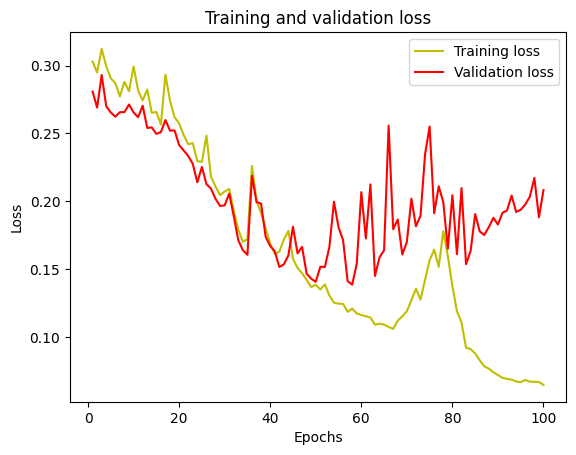

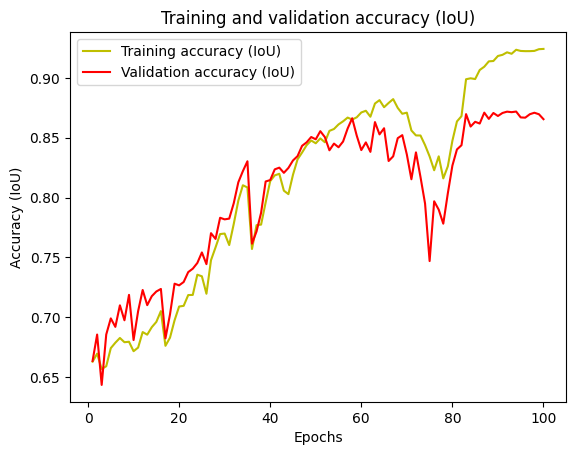

In [18]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history
history= model_final
# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy (or IoU if you tracked IoU)
acc = history.history['jacard_coef']  # Assuming 'jacard_coef' is recorded during training
val_acc = history.history['val_jacard_coef']  # Assuming 'val_jacard_coef' is recorded during training

plt.plot(epochs, acc, 'y', label='Training accuracy (IoU)')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy (IoU)')
plt.title('Training and validation accuracy (IoU)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (IoU)')
plt.legend()
plt.show()


In [19]:
## Predictions

### Predictions


### Checking the predictions 
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

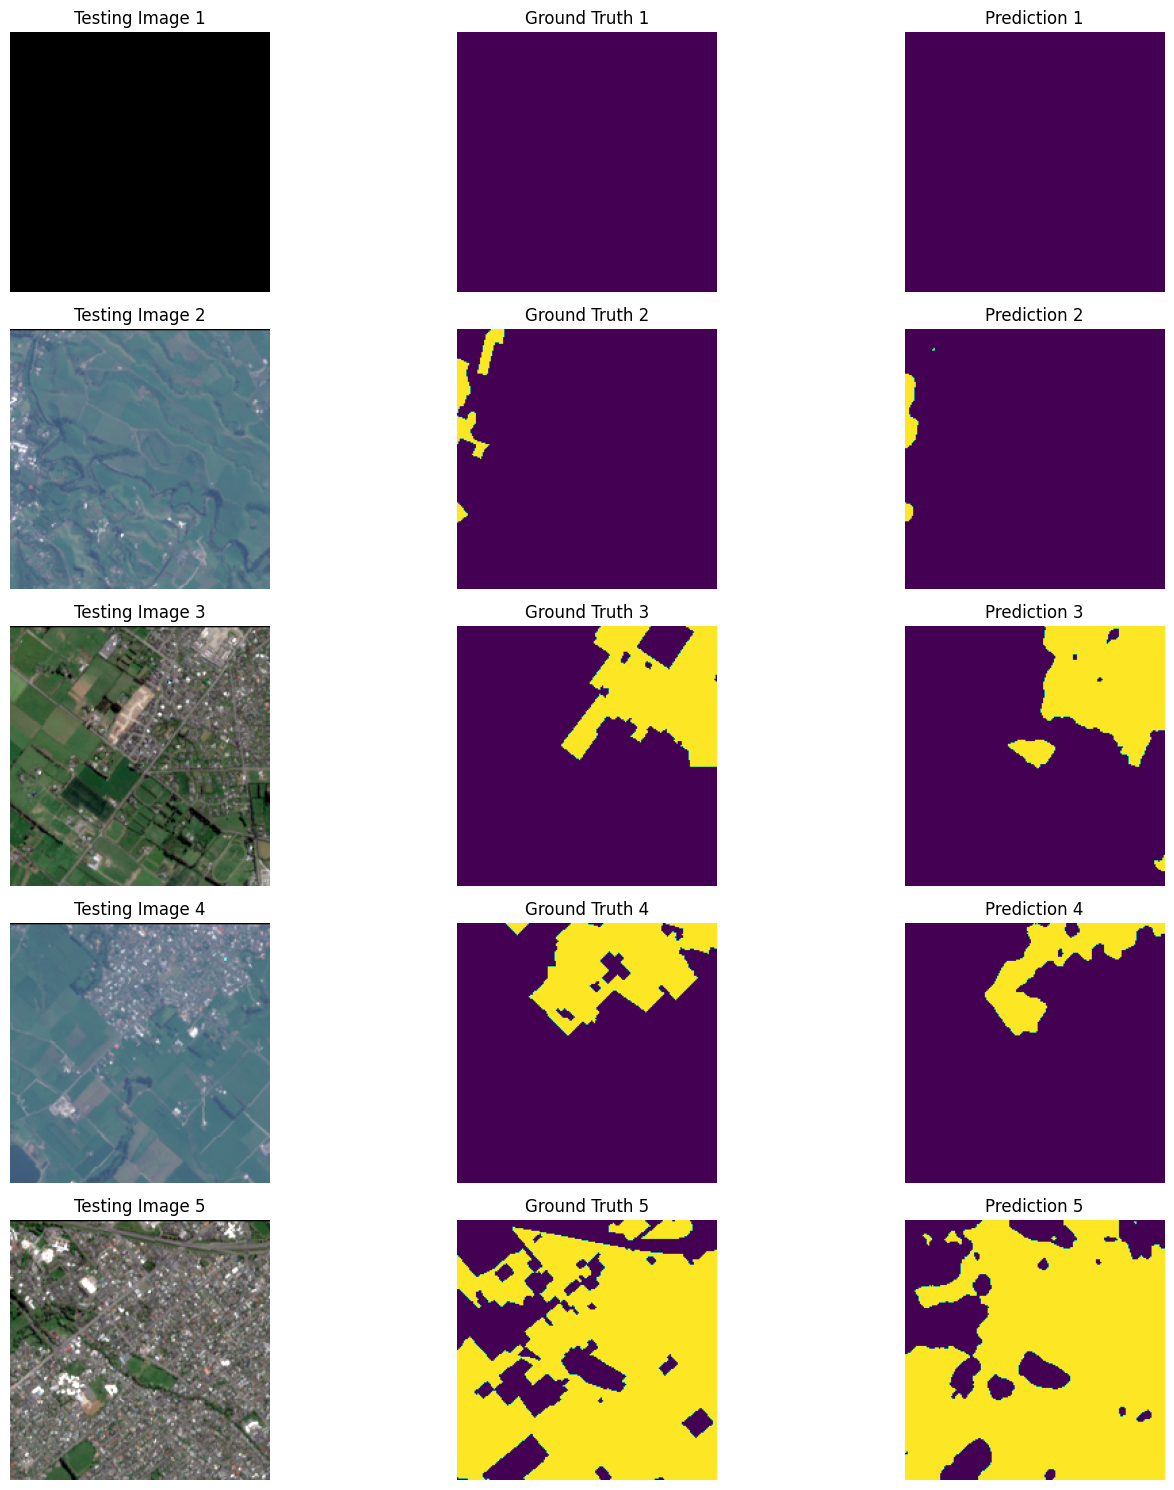

In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Number of images to show
num_images = 5

# Create subplots for 5 images
plt.figure(figsize=(15, 15))

for i in range(num_images):
    # Randomly pick a test image and corresponding ground truth
    test_img_number = random.randint(0, len(X_test)- 1)
    test_img = X_test[test_img_number]
    ground_truth = y_test_argmax[test_img_number]

    # Prepare the test image for prediction
    test_img_input = np.expand_dims(test_img, 0)
    
    # Make prediction
    prediction = model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0,:,:]
    
    # Plot the images
    plt.subplot(num_images, 3, i * 3 + 1)
    plt.title(f'Testing Image {i + 1}')
    plt.imshow(test_img)
    plt.axis('off')
    
    plt.subplot(num_images, 3, i * 3 + 2)
    plt.title(f'Ground Truth {i + 1}')
    plt.imshow(ground_truth)
    plt.axis('off')
    
    plt.subplot(num_images, 3, i * 3 + 3)
    plt.title(f'Prediction {i + 1}')
    plt.imshow(predicted_img)
    plt.axis('off')

# Show the plots
plt.tight_layout()
plt.show()
